Meshing
======

Underworld uses a mesh (grid) of nodes to solve the finite element (FE) variables on. These FE variables are examined in more detail in the next guide **03_FEVariables.ipynb**. This notebook will go through a few different examples of what can be done with meshes using underworld. Each example will be increasingly complex, so do not be too worried if they take a few readings to understand.

**This notebook is broken down into the following examples:**

1. setting and visualising up meshes
2. remeshing data onto different mesh sizes
3. different mesh geometry types

**Keywords:** meshes, mesh geometry

Firstly, load the usual functions.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np

Setting up meshes
-----

**Set parameters**



In [2]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 8

**Create mesh objects for the original resolution**

The following command shows how to do create a mesh consiting of a $8\times8$ linear, constant grid (``elementType = "Q1/dQ0"``). The mesh will have the height and lengths specified above. 

The other ``elementTypes`` are examined below.

In [3]:
# setup the mesh
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight))
# copy element mesh
linearMesh   = elementMesh
# copy the subMesh to the constantMesh object
constantMesh = elementMesh.subMesh 

Note that the mesh types have different sizes.

In [4]:
print(' Number of mesh points (Total) = {0:4d}'.format(len(elementMesh.data)))
print('Number of mesh points (linear) = {0:4d}'.format(len(linearMesh.data)))
print('      Number of submesh points = {0:4d}'.format(len(constantMesh.data)))

 Number of mesh points (Total) =   81
Number of mesh points (linear) =   81
      Number of submesh points =   64


**Plot representation of mesh**

To see what the basic mesh looks like we plot it using the ``.Mesh`` function in ``gLucifer``.

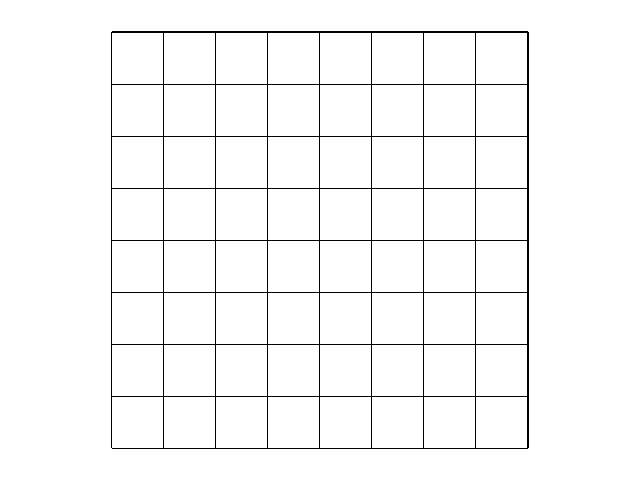

In [5]:
figMesh = plt.Figure()
figMesh.Mesh(linearMesh, colourBar=False)
figMesh.show()

**Sub meshes**

In the above cell, the **main mesh (``Q1``) has node points on the edge of the cell** and is stored in the ``elementMesh`` obejct, while the **sub mesh (``dQ0``) has node points inside the cell** and stored in the ``elementMesh.subMesh`` object. The sub mesh is only used for the pressure field since the pressure is evaluated inside the cell, whereas the temperature and velocity fields are evaluated on the edges. This means that the temperature and velocity field edges are the true simulation boundary, which is used when setting up boundary conditions below.

**Visualise node points of the mesh and submesh**

Here we will use particle swarms to mark the node points on the mesh and sub mesh. For more information on particle swarms see the user guide **05_Swarms.ipynb**.

In [6]:
# setup a new swarm. At this point there is no data in the swarm
SwarmForElementMesh = uw.swarm.Swarm( feMesh=elementMesh )
# setup an array containing the position data from the elementMesh data
SwarmCoords = elementMesh.data
# use this array to add particles to the newly created swarm
SwarmForElementMesh.add_particles_with_coordinates(SwarmCoords)

# setup a new swarm
SwarmForConstantMesh = uw.swarm.Swarm( feMesh=elementMesh ) # note this must be the whole mesh; elementMesh
# setup an array containing the position data from the constantMesh data
SwarmCoords = constantMesh.data
# use this array to add particles to the newly created swarm
SwarmForConstantMesh.add_particles_with_coordinates(SwarmCoords)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int32)

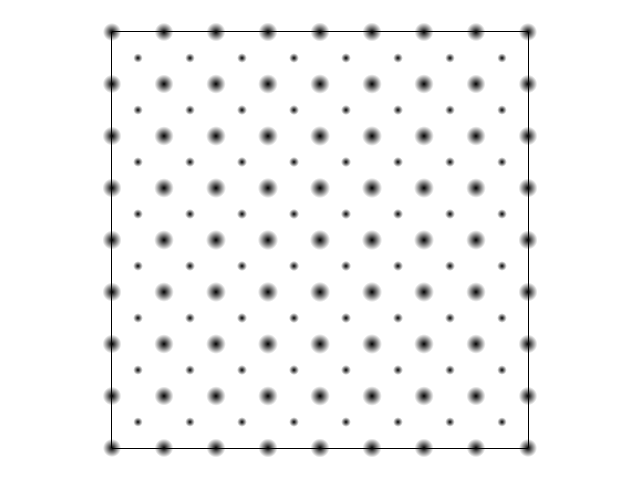

In [7]:
fig1 = plt.Figure()
fig1.Points( swarm=SwarmForElementMesh , pointSize=20, colourBar = False )
fig1.Points( swarm=SwarmForConstantMesh, pointSize=10, colourBar = False )
fig1.show()

In the above figure the large points are on the vertex node points for the ``elementMesh`` grid, while the smaller points denote the ``subMesh``. The larger mesh is used for the temperature and velocity fields, while the pressure field is used on the sub mesh. This example shows the ``elementType`` geometry of ``"Q1/dQ0"``, these are explained along with other mesh types below.

Remeshing data
------

To demonstrate what can be done with meshes this example will change the resolution of a set of initial conditions to a lower resolution. 

**Generate some data on high resolution mesh**

Here we set the simulation box height and length as well as the resolutions to use later. 

The parameter *res* is the larger resolution we will set up some data on using a finite element (FE) variable, while *newres* is the desired resolution after resampling. A full discussion of FE variables is left until the next user guide.

In this case we will generate input on a mesh that is $128\times128$ and remap it down to a low resolution mesh. Mapping up in resolution is just a case of changing the value of *newres*.


In [8]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 128
newres = 16

Create the large mesh

In [9]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight))
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh 

Create temperature initial conditions that will not map well to low resolution.

In [10]:
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )
numberSin = 20.0
for index, coord in enumerate(linearMesh.data):
    phase = math.pi * numberSin * coord[0]/boxLength + 10.0 * coord[1]
    temperatureField.data[index] = math.cos( phase )

Plot loaded temperature field


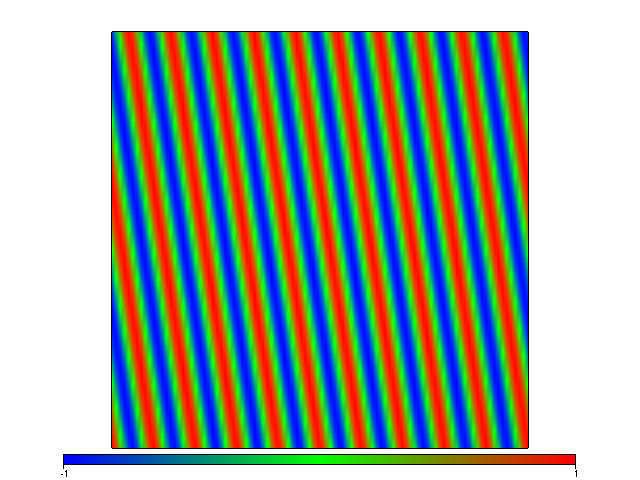

In [11]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, linearMesh, colours="blue green red")
figtemp.show()

**Remesh initial conditions**

Remesh temperature field onto a new resolution. Mesh resolution set by *newres* variable defined above.

In [12]:
print('Remeshing from a square grid of {0:3d} mesh points to {1:3d} mesh points'.format(res, newres))

Remeshing from a square grid of 128 mesh points to  16 mesh points


Create new mesh with *newres*.

In [13]:
elementMeshNew = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                           elementRes  = (newres, newres), 
                                           minCoord    = (0., 0.), 
                                           maxCoord    = (boxLength, boxHeight))
linearMeshNew   = elementMeshNew
constantMeshNew = elementMeshNew.subMesh 

Create new FE variable for the new temperature field on the new mesh.

In [14]:
temperatureFieldNew = uw.fevariable.FeVariable( feMesh=linearMeshNew,   nodeDofCount=1 )

**Re-map values**

Re-map values from original temperature field data onto the new temperature field with the new mesh.

The line below passes the new mesh information, contained in *linearMeshnew*, into the evaluate function contained in the *temperatureField* structure. What this does is then evaluate the temperature value at each point in the new linear mesh. These values are then copied into the new temperature field data values, stored in *temperatureFieldnew*.

In [15]:
temperatureFieldNew.data[:] = temperatureField.evaluate(linearMeshNew)

**Plot previous and remeshed temperature fields**

These plots will look identical for high enough resolution. Low resolution mapping will remove the details compared to the figure above.

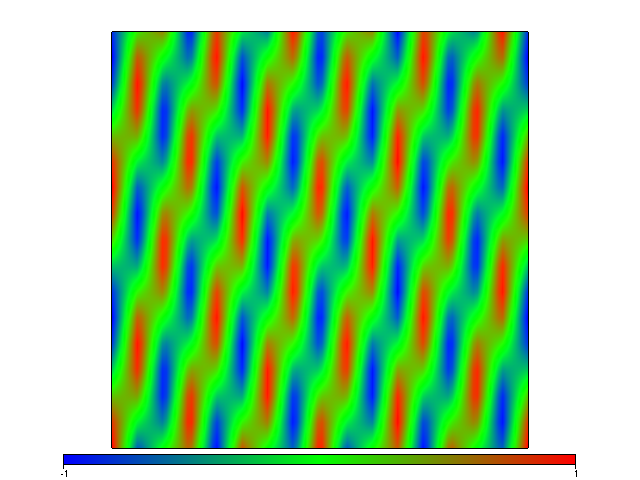

In [16]:
figtemp = plt.Figure()
figtemp.Surface(temperatureFieldNew, linearMeshNew, colours="blue green red")
figtemp.show()

**So what else has changed?**

Since the temperature field is remapped onto a new mesh, the values in space change if the mesh is sufficiently different, in addition the way they are stored has changed a lot. 

Firstly the size of the data arrays has changed from 129$^2$ (0-128 mesh points in a square grid) to 9$^2$. Secondly the exact data stored on a given index has changed. For example, say T[10] = 0.50 on the original mesh, but after re-meshing the index 10 might now refer to a value on the boundary of the new mesh, which might now give T[10] = 0. 

Both of these are demonstrated below.

In [17]:
print 'Previous temperature field data size was {0:3d}^2'.format(int(math.sqrt(len(temperatureField.data))))
print 'New temperature fielddata size is {0:3d}^2'.format(int(math.sqrt(len(temperatureFieldNew.data))))

Previous temperature field data size was 129^2
New temperature fielddata size is  17^2


In [18]:
if(res < newres):
    testpoint = int(res*res / 2)
    print 'Mid point of original mesh in original then new temperature variable:'
else:
    testpoint = int(newres*newres / 2)
    print 'Mid point of new (smaller) mesh in original then new temperature variable:'

# note that the [0] at the end retreves the value from the truple.
oldValue = temperatureField.data[testpoint][0]
newValue = temperatureFieldNew.data[testpoint][0]
print '  T_old({0:4d}) = {1:.3f}'.format(testpoint,oldValue)
print '  T_new({0:4d}) = {1:.3f}'.format(testpoint,newValue)

Mid point of new (smaller) mesh in original then new temperature variable:
  T_old( 128) = 1.000
  T_new( 128) = -0.433


These values will typically be different, depending on the actual values in the temperature field.

Different types of mesh geometries
-----

Here we will examine the different mesh types that are available in ``underworld``.

The geometry of the mesh and subMesh is controlled from the ``elementType`` field in the mesh creation command. The mesh types are entered such that the first part is for the edge mesh, while the second part is for the sub mesh used by the pressure field. For example the ``Q1/dQ0`` mesh means that the edges of each rectangular cell use ``Q1`` and the sub mesh uses ``dQ0``. In particular this means that the are only nodes on the vertices of the edge mesh, and there is a single node in the centre of each cell. A full list of element types can be found [here](http://femtable.org/).

List of ``element types`` available in ``underworld``:

1. ``Q1/dQ0``: contant mesh with a single node in the centre of the cell
2. ``Q1/dQ1``: more nodes in the centre of the cell

In [19]:
res = 8

In [20]:
# setup the mesh
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight))
# copy element mesh
linearMesh   = elementMesh
# copy the subMesh to the constantMesh object
constantMesh = elementMesh.subMesh 

In [21]:
# setup a new swarm. At this point there is no data in the swarm
SwarmForElementMesh = uw.swarm.Swarm( feMesh=elementMesh )
# setup an array containing the position data from the elementMesh data
SwarmCoords = elementMesh.data
# use this array to add particles to the newly created swarm
SwarmForElementMesh.add_particles_with_coordinates(SwarmCoords)

# setup a new swarm
SwarmForConstantMesh = uw.swarm.Swarm( feMesh=elementMesh ) # note this must be the whole mesh; elementMesh
# setup an array containing the position data from the constantMesh data
SwarmCoords = constantMesh.data
# use this array to add particles to the newly created swarm
SwarmForConstantMesh.add_particles_with_coordinates(SwarmCoords)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int32)

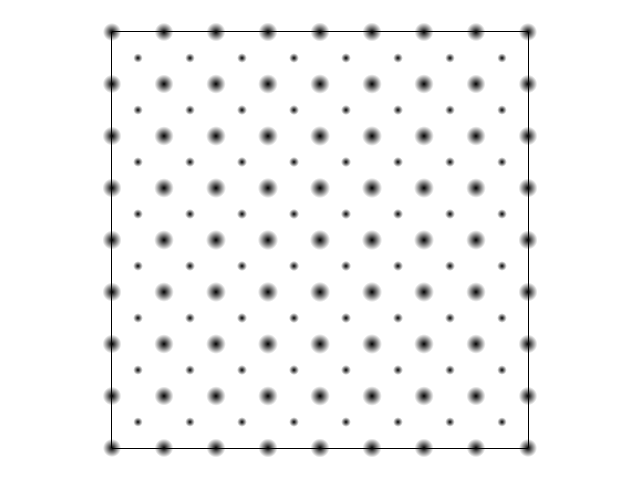

In [22]:
fig1 = plt.Figure()
fig1.Points( swarm=SwarmForElementMesh , pointSize=20, colourBar = False )
fig1.Points( swarm=SwarmForConstantMesh, pointSize=10, colourBar = False )
fig1.show()